In [60]:
import re
import math
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import kaleido
import ipywidgets as widgets
from plotly.subplots import make_subplots
from IPython.display import display, Image

# Statistical analysis
from scipy.stats import chi2_contingency, boxcox, skew, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ML libraries and utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter tuning
import xgboost as xgb
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
def read_excel_data(file_path, sheet_names):
    data_frames = []
    
    for sheet_name in sheet_names:
      df = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
      data_frames.append(df)
    
    return data_frames

In [3]:
# Read Excel sheets into DataFrames
sheet_names = ['loan_information', 'Employment', 'Personal_information', 'Other_information']
dfs = read_excel_data("Credit_Risk_Dataset.xlsx", sheet_names)

loan_information = dfs[0]
employment = dfs[1]
personal_information = dfs[2]
other_information = dfs[3]

# Standardize the 'User_id' column names across all DataFrames
employment.rename(columns={'User id': 'User_id'}, inplace=True)
personal_information.rename(columns={'User id': 'User_id'}, inplace=True)

# Merge 'loan_information' and 'employment' DataFrames based on 'User_id'
merged_df = pd.merge(loan_information, employment, on='User_id')

# Merge the previously merged DataFrame with 'personal_information' based on 'User_id'
merged_df = pd.merge(merged_df, personal_information, on='User_id')

# Merge the previously merged DataFrame with 'other_information' based on 'User_id'
merged_df = pd.merge(merged_df, other_information, on='User_id')
df = merged_df
df.to_csv("merged_data.csv", index=False)

## Data Overview

In [4]:
df = pd.read_csv("merged_data.csv")
df.head()

,User_id,Loan Category,Amount,Interest Rate,Tenure(years),Employmet type,Tier of Employment,Industry,Role,Work Experience,...,Home,Pincode,Social Profile,Is_verified,Delinq_2yrs,Total Payement,Received Principal,Interest Received,Number of loans,Defaulter
0,7013527,Consolidation,55884.0,11.84,6,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,...,rent,XX852X,No,NaN,0,1824.150000,971.46,852.69,0,1
1,7014291,Consolidation,55511.0,16.94,4,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,...,mortgage,XX286X,NaN,Source Verified,0,22912.532998,18000.00,4912.53,0,0
2,7014327,Consolidation,12289.0,11.84,6,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,...,own,XX113X,No,NaN,0,7800.440000,4489.76,3310.68,0,1
3,7014304,Credit Card,29324.0,14.71,4,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,...,rent,XX941X,Yes,NaN,0,6672.050000,5212.29,1459.76,0,0
4,7031995,Credit Card,30252.0,14.71,4,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,...,rent,XX913X,No,Verified,0,11793.001345,10000.00,1793.00,0,0


In [5]:
df = df.drop(columns=['Pincode', 'Role', 'Industry', 'User_id'])

df.rename(columns={
    'Employmet type': 'Employment type',
    'Total Payement ': 'Total Payment',
    'Total Income(PA)': 'Total Income',
    'Tenure(years)': 'Loan Tenure'
}, inplace=True)

df['Employment type'] = df['Employment type'].str.replace('Self - Employeed', 'Self Employed')

df.head()

,Loan Category,Amount,Interest Rate,Loan Tenure,Employment type,Tier of Employment,Work Experience,Total Income,Gender,Married,Dependents,Home,Social Profile,Is_verified,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
0,Consolidation,55884.0,11.84,6,Salaried,B,1-2,125000.0,Female,Yes,4,rent,No,NaN,0,1824.150000,971.46,852.69,0,1
1,Consolidation,55511.0,16.94,4,Self Employed,D,10+,61000.0,Female,No,1,mortgage,NaN,Source Verified,0,22912.532998,18000.00,4912.53,0,0
2,Consolidation,12289.0,11.84,6,NaN,NaN,5-10,100000.0,Other,NaN,3,own,No,NaN,0,7800.440000,4489.76,3310.68,0,1
3,Credit Card,29324.0,14.71,4,NaN,NaN,2-3,30000.0,Male,NaN,1,rent,Yes,NaN,0,6672.050000,5212.29,1459.76,0,0
4,Credit Card,30252.0,14.71,4,NaN,NaN,10+,65000.0,Male,NaN,3,rent,No,Verified,0,11793.001345,10000.00,1793.00,0,0


In [6]:
df.describe()

,Amount,Interest Rate,Loan Tenure,Total Income,Dependents,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
count,1.118030e+05,143727.000000,143727.000000,1.437270e+05,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.376458e+05,12.038703,4.514503,7.242256e+04,1.997113,0.276601,10840.882025,8407.001538,2352.729746,0.005573,0.093712
std,1.575427e+05,3.880204,0.874241,5.539328e+04,1.411317,0.789019,8613.421536,7224.396032,2447.759754,0.098785,0.291429
min,0.000000e+00,5.420000,4.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.837950e+04,9.180000,4.000000,4.500000e+04,1.000000,0.000000,4674.775000,3104.160000,841.685000,0.000000,0.000000
50%,7.660300e+04,11.840000,4.000000,6.180000e+04,2.000000,0.000000,8212.410000,6000.000000,1632.240000,0.000000,0.000000
75%,2.054645e+05,14.440000,6.000000,8.600000e+04,3.000000,0.000000,14175.769677,11664.365000,2904.770000,0.000000,0.000000
max,8.000078e+06,23.540000,6.000000,7.141778e+06,4.000000,22.000000,57777.579870,35000.010000,24205.620000,5.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143727 entries, 0 to 143726
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Loan Category       143727 non-null  object 
 1   Amount              111803 non-null  float64
 2   Interest Rate       143727 non-null  float64
 3   Loan Tenure         143727 non-null  int64  
 4   Employment type     59085 non-null   object 
 5   Tier of Employment  59085 non-null   object 
 6   Work Experience     143723 non-null  object 
 7   Total Income        143727 non-null  float64
 8   Gender              143727 non-null  object 
 9   Married             95584 non-null   object 
 10  Dependents          143727 non-null  int64  
 11  Home                143727 non-null  object 
 12  Social Profile      95871 non-null   object 
 13  Is_verified         107924 non-null  object 
 14  Delinq_2yrs         143727 non-null  int64  
 15  Total Payment       143727 non-nul

In [8]:
df.describe()

,Amount,Interest Rate,Loan Tenure,Total Income,Dependents,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
count,1.118030e+05,143727.000000,143727.000000,1.437270e+05,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.376458e+05,12.038703,4.514503,7.242256e+04,1.997113,0.276601,10840.882025,8407.001538,2352.729746,0.005573,0.093712
std,1.575427e+05,3.880204,0.874241,5.539328e+04,1.411317,0.789019,8613.421536,7224.396032,2447.759754,0.098785,0.291429
min,0.000000e+00,5.420000,4.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.837950e+04,9.180000,4.000000,4.500000e+04,1.000000,0.000000,4674.775000,3104.160000,841.685000,0.000000,0.000000
50%,7.660300e+04,11.840000,4.000000,6.180000e+04,2.000000,0.000000,8212.410000,6000.000000,1632.240000,0.000000,0.000000
75%,2.054645e+05,14.440000,6.000000,8.600000e+04,3.000000,0.000000,14175.769677,11664.365000,2904.770000,0.000000,0.000000
max,8.000078e+06,23.540000,6.000000,7.141778e+06,4.000000,22.000000,57777.579870,35000.010000,24205.620000,5.000000,1.000000


## Missing Data Analysis

In [9]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Amount                31924
Employment type       84642
Tier of Employment    84642
Work Experience           4
Married               48143
Social Profile        47856
Is_verified           35803
dtype: int64

In [10]:
missing_data_proportion = df.isnull().mean() * 100
missing_data_proportion = missing_data_proportion[missing_data_proportion > 0]
missing_data_proportion = missing_data_proportion.sort_values(ascending=False)
missing_data_proportion_formatted = missing_data_proportion.apply(lambda x: f"{x:.2f}%")
missing_data_proportion_formatted

Employment type       58.89%
Tier of Employment    58.89%
Married               33.50%
Social Profile        33.30%
Is_verified           24.91%
Amount                22.21%
Work Experience        0.00%
dtype: object

In [11]:
num_imputer = SimpleImputer(strategy='median')  # For numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns

# Select numerical and categorical columns
numerical_cols = ['Amount']
categorical_cols = ['Employment type', 'Tier of Employment', 'Married', 'Social Profile', 'Is_verified']

df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [12]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Work Experience    4
dtype: int64

In [13]:
print(df['Work Experience'].unique())
missing_work_exp = df[df['Work Experience'].isnull()]
print(missing_work_exp)

['1-2' '10+' '5-10' '2-3' '3-5' '0' '<1' nan 0]
        Loan Category    Amount  Interest Rate  Loan Tenure Employment type  \
2413    Consolidation  300054.0          16.05            6        Salaried   
54119     Credit Card   76603.0           5.98            4        Salaried   
125065  Consolidation   16931.0          13.09            4        Salaried   
130563       Business   61204.0          22.13            6        Salaried   

       Tier of Employment Work Experience  Total Income  Gender Married  \
2413                    B             NaN       97000.0    Male      No   
54119                   A             NaN       30000.0    Male     Yes   
125065                  B             NaN       25000.0   Other     Yes   
130563                  B             NaN      120000.0  Female     Yes   

        Dependents      Home Social Profile      Is_verified  Delinq_2yrs  \
2413             3  mortgage             No     Not Verified            0   
54119            3      re

In [14]:
df['Work Experience'].replace(['0', 'nan 0', np.nan], '<1', inplace=True)
df = df.dropna(subset=['Work Experience'])
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Series([], dtype: int64)

In [15]:
df.describe()

,Amount,Interest Rate,Loan Tenure,Total Income,Dependents,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
count,1.437270e+05,143727.000000,143727.000000,1.437270e+05,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.240872e+05,12.038703,4.514503,7.242256e+04,1.997113,0.276601,10840.882025,8407.001538,2352.729746,0.005573,0.093712
std,1.412468e+05,3.880204,0.874241,5.539328e+04,1.411317,0.789019,8613.421536,7224.396032,2447.759754,0.098785,0.291429
min,0.000000e+00,5.420000,4.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.663650e+04,9.180000,4.000000,4.500000e+04,1.000000,0.000000,4674.775000,3104.160000,841.685000,0.000000,0.000000
50%,7.660300e+04,11.840000,4.000000,6.180000e+04,2.000000,0.000000,8212.410000,6000.000000,1632.240000,0.000000,0.000000
75%,1.673170e+05,14.440000,6.000000,8.600000e+04,3.000000,0.000000,14175.769677,11664.365000,2904.770000,0.000000,0.000000
max,8.000078e+06,23.540000,6.000000,7.141778e+06,4.000000,22.000000,57777.579870,35000.010000,24205.620000,5.000000,1.000000


## Feature Distribution and Univariate Analysis

### Categorical and numerical feature analysis

In [16]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")

print("\nNumerical Features:")
print(numerical_features)

print("\nDistinct values for each numerical feature:")
for feature in numerical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    if distinct_values < 6:
        print(f"Values: {unique_values}")

Categorical Features:
['Loan Category', 'Employment type', 'Tier of Employment', 'Work Experience', 'Gender', 'Married', 'Home', 'Social Profile', 'Is_verified']

Distinct values for each categorical feature:
Loan Category: 7 unique values
Values: ['Consolidation' 'Credit Card' 'Home' 'Other ' 'Business' 'Car '
 'Medical ']
Employment type: 2 unique values
Values: ['Salaried' 'Self Employed']
Tier of Employment: 7 unique values
Values: ['B' 'D' 'C' 'A' 'E' 'G' 'F']
Work Experience: 7 unique values
Values: ['1-2' '10+' '5-10' '2-3' '3-5' '<1' 0]
Gender: 3 unique values
Values: ['Female' 'Other' 'Male']
Married: 2 unique values
Values: ['Yes' 'No']
Home: 5 unique values
Values: ['rent' 'mortgage' 'own' 'none' 'other']
Social Profile: 2 unique values
Values: ['No' 'Yes']
Is_verified: 3 unique values
Values: ['Not Verified' 'Source Verified' 'Verified']

Numerical Features:
['Amount', 'Interest Rate', 'Loan Tenure', 'Total Income', 'Dependents', 'Delinq_2yrs', 'Total Payment', 'Received Pr

If a discrete numerical feature has many distinct values (e.g., 0 to 10+ dependents), it can be treated as numerical discrete.
If a discrete numerical feature has few distinct values (e.g., 0 to 4+ dependents), it can be treated as categorical.

Loan Tenure has 2 unique values, Dependents has 5 unique values, Number of loans has 5 unique values and Defaulter has 2 unique values.

The Defaulter variable is a categorical feature since it has two distinct values, 0 and 1, representing whether a user is a defaulter or not. It should be treated as a binary categorical variable, not as a numerical one.

In [17]:
df['Loan Tenure'] = df['Loan Tenure'].astype('category')
df['Dependents'] = df['Dependents'].astype('category')
df['Number of loans'] = df['Number of loans'].astype('category')
df['Defaulter'] = df['Defaulter'].astype('category')

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical Features:")
print(categorical_features)

numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical Features:")
print(numerical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")


Categorical Features:
['Loan Category', 'Loan Tenure', 'Employment type', 'Tier of Employment', 'Work Experience', 'Gender', 'Married', 'Dependents', 'Home', 'Social Profile', 'Is_verified', 'Number of loans', 'Defaulter']

Numerical Features:
['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

Distinct values for each categorical feature:
Loan Category: 7 unique values
Values: ['Consolidation' 'Credit Card' 'Home' 'Other ' 'Business' 'Car '
 'Medical ']
Loan Tenure: 2 unique values
Values: [6, 4]
Categories (2, int64): [4, 6]
Employment type: 2 unique values
Values: ['Salaried' 'Self Employed']
Tier of Employment: 7 unique values
Values: ['B' 'D' 'C' 'A' 'E' 'G' 'F']
Work Experience: 7 unique values
Values: ['1-2' '10+' '5-10' '2-3' '3-5' '<1' 0]
Gender: 3 unique values
Values: ['Female' 'Other' 'Male']
Married: 2 unique values
Values: ['Yes' 'No']
Dependents: 5 unique values
Values: [4, 1, 3, 0, 2]
Categories (5, in

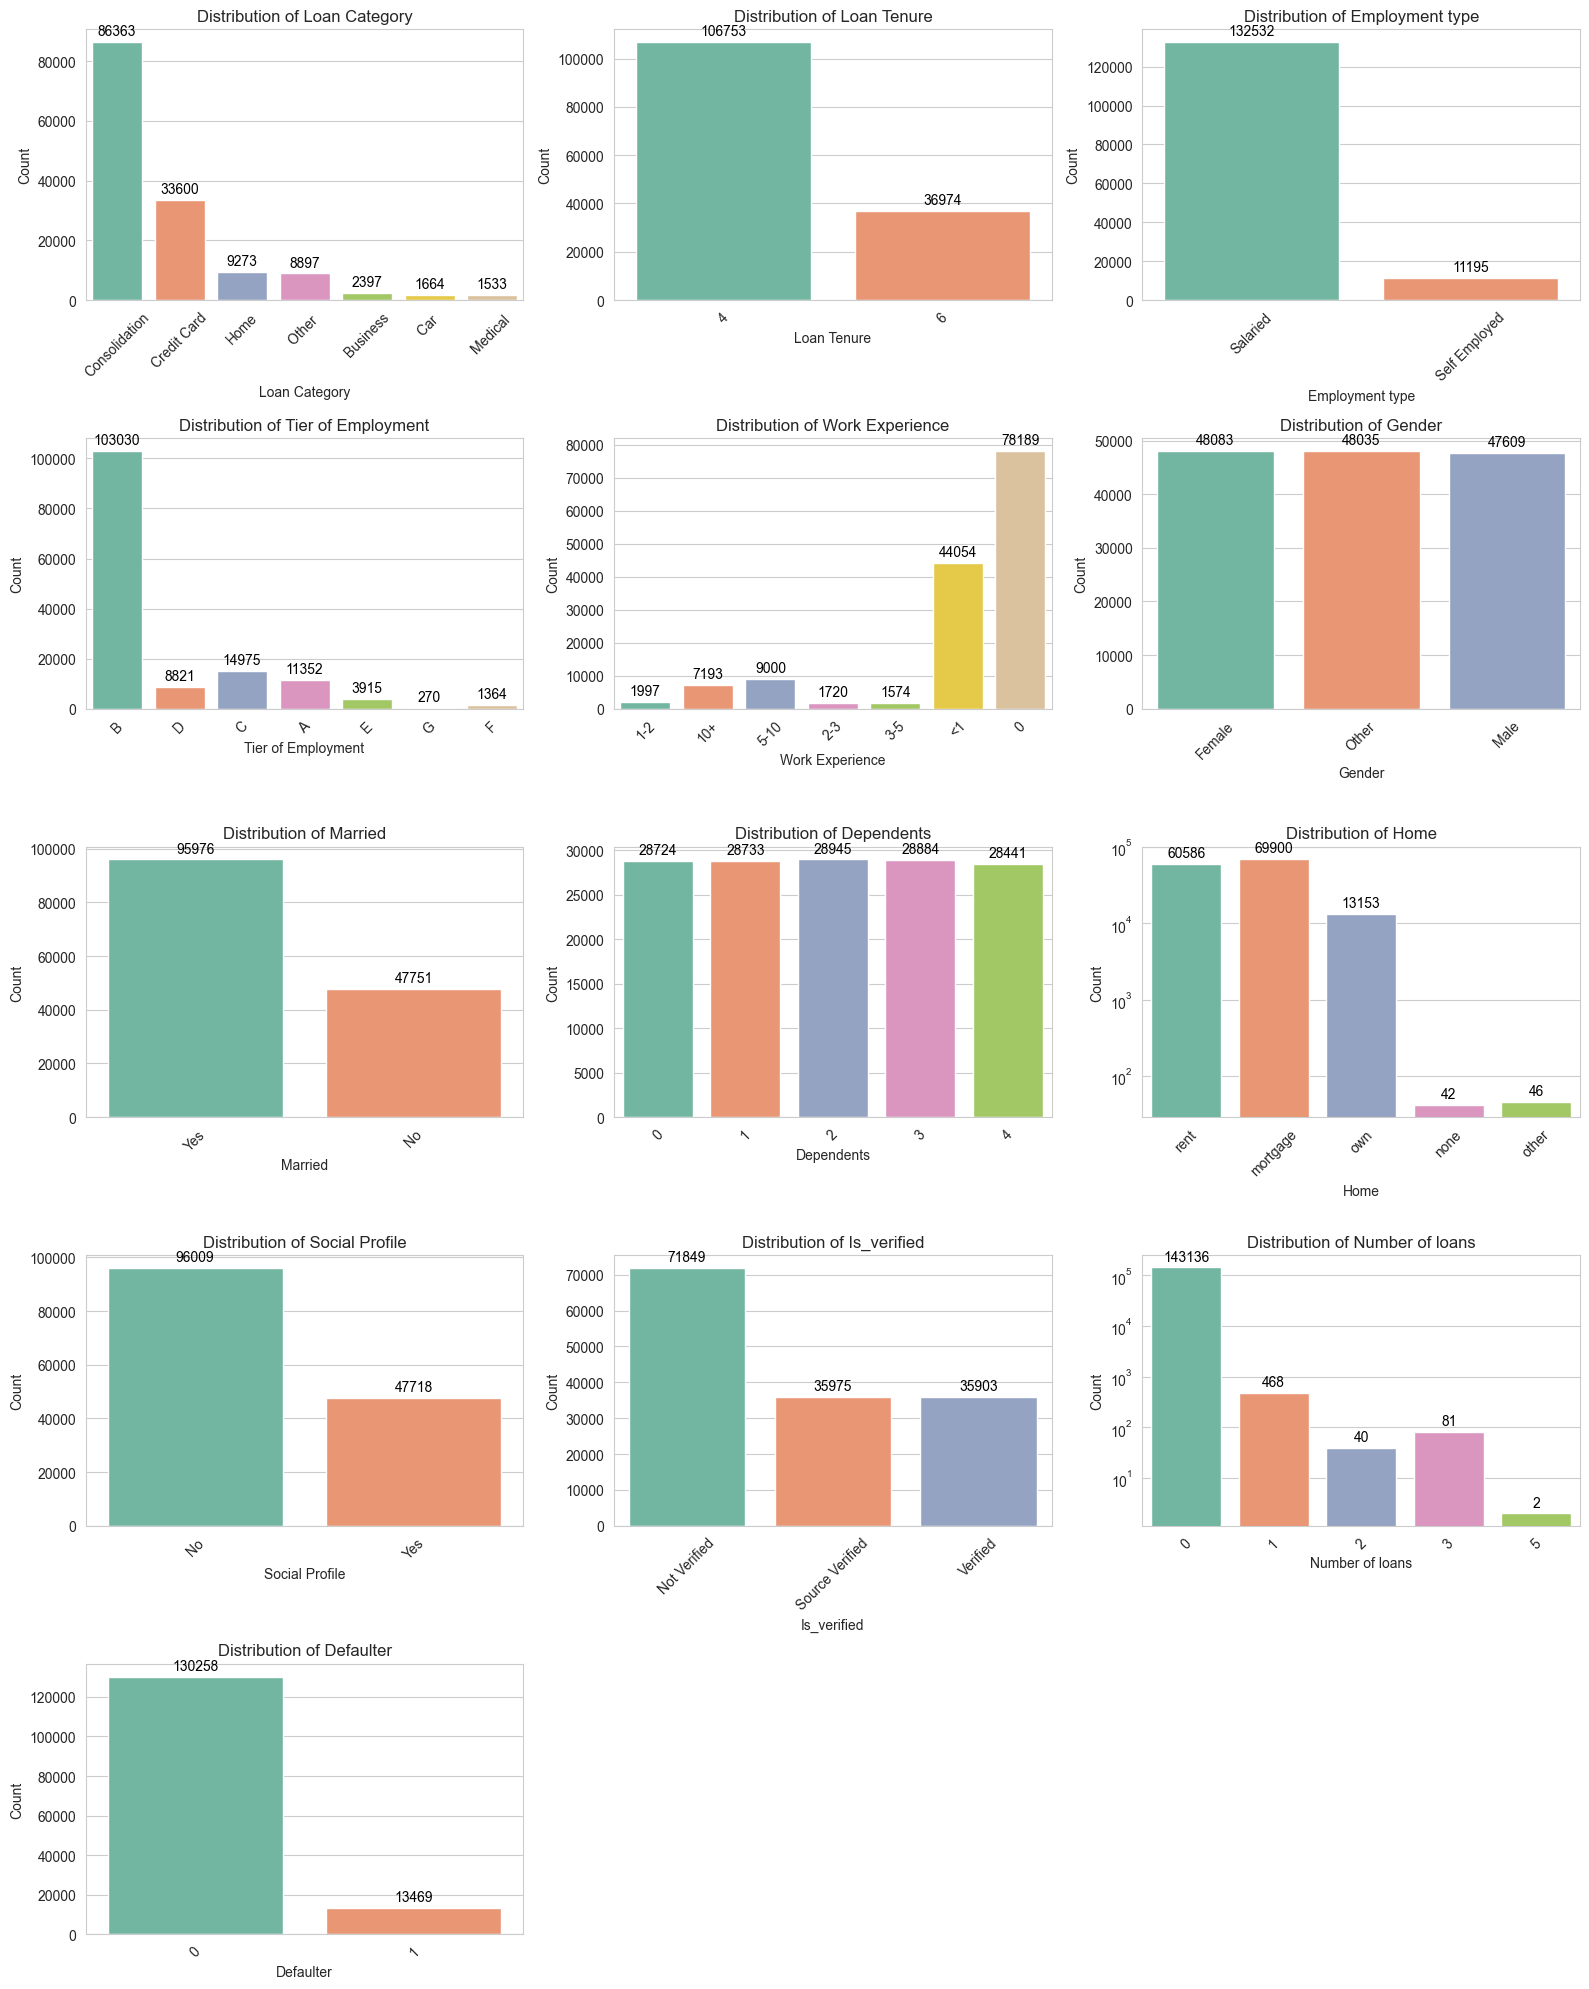

In [18]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type', 
                        'Tier of Employment', 'Work Experience', 'Gender', 
                        'Married', 'Dependents', 'Home', 'Social Profile', 
                        'Is_verified', 'Number of loans', 'Defaulter']

cols = 3
num_features = len(categorical_features)
rows = (num_features // cols) + 1 if num_features % cols != 0 else num_features // cols

plt.figure(figsize=(16, 4 * rows))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(rows, cols, i)
    
    if feature in ['Number of loans', 'Home']:
        ax = sns.countplot(data=df, x=feature, palette='Set2')
        plt.yscale('log')
    else:
        ax = sns.countplot(data=df, x=feature, palette='Set2')
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

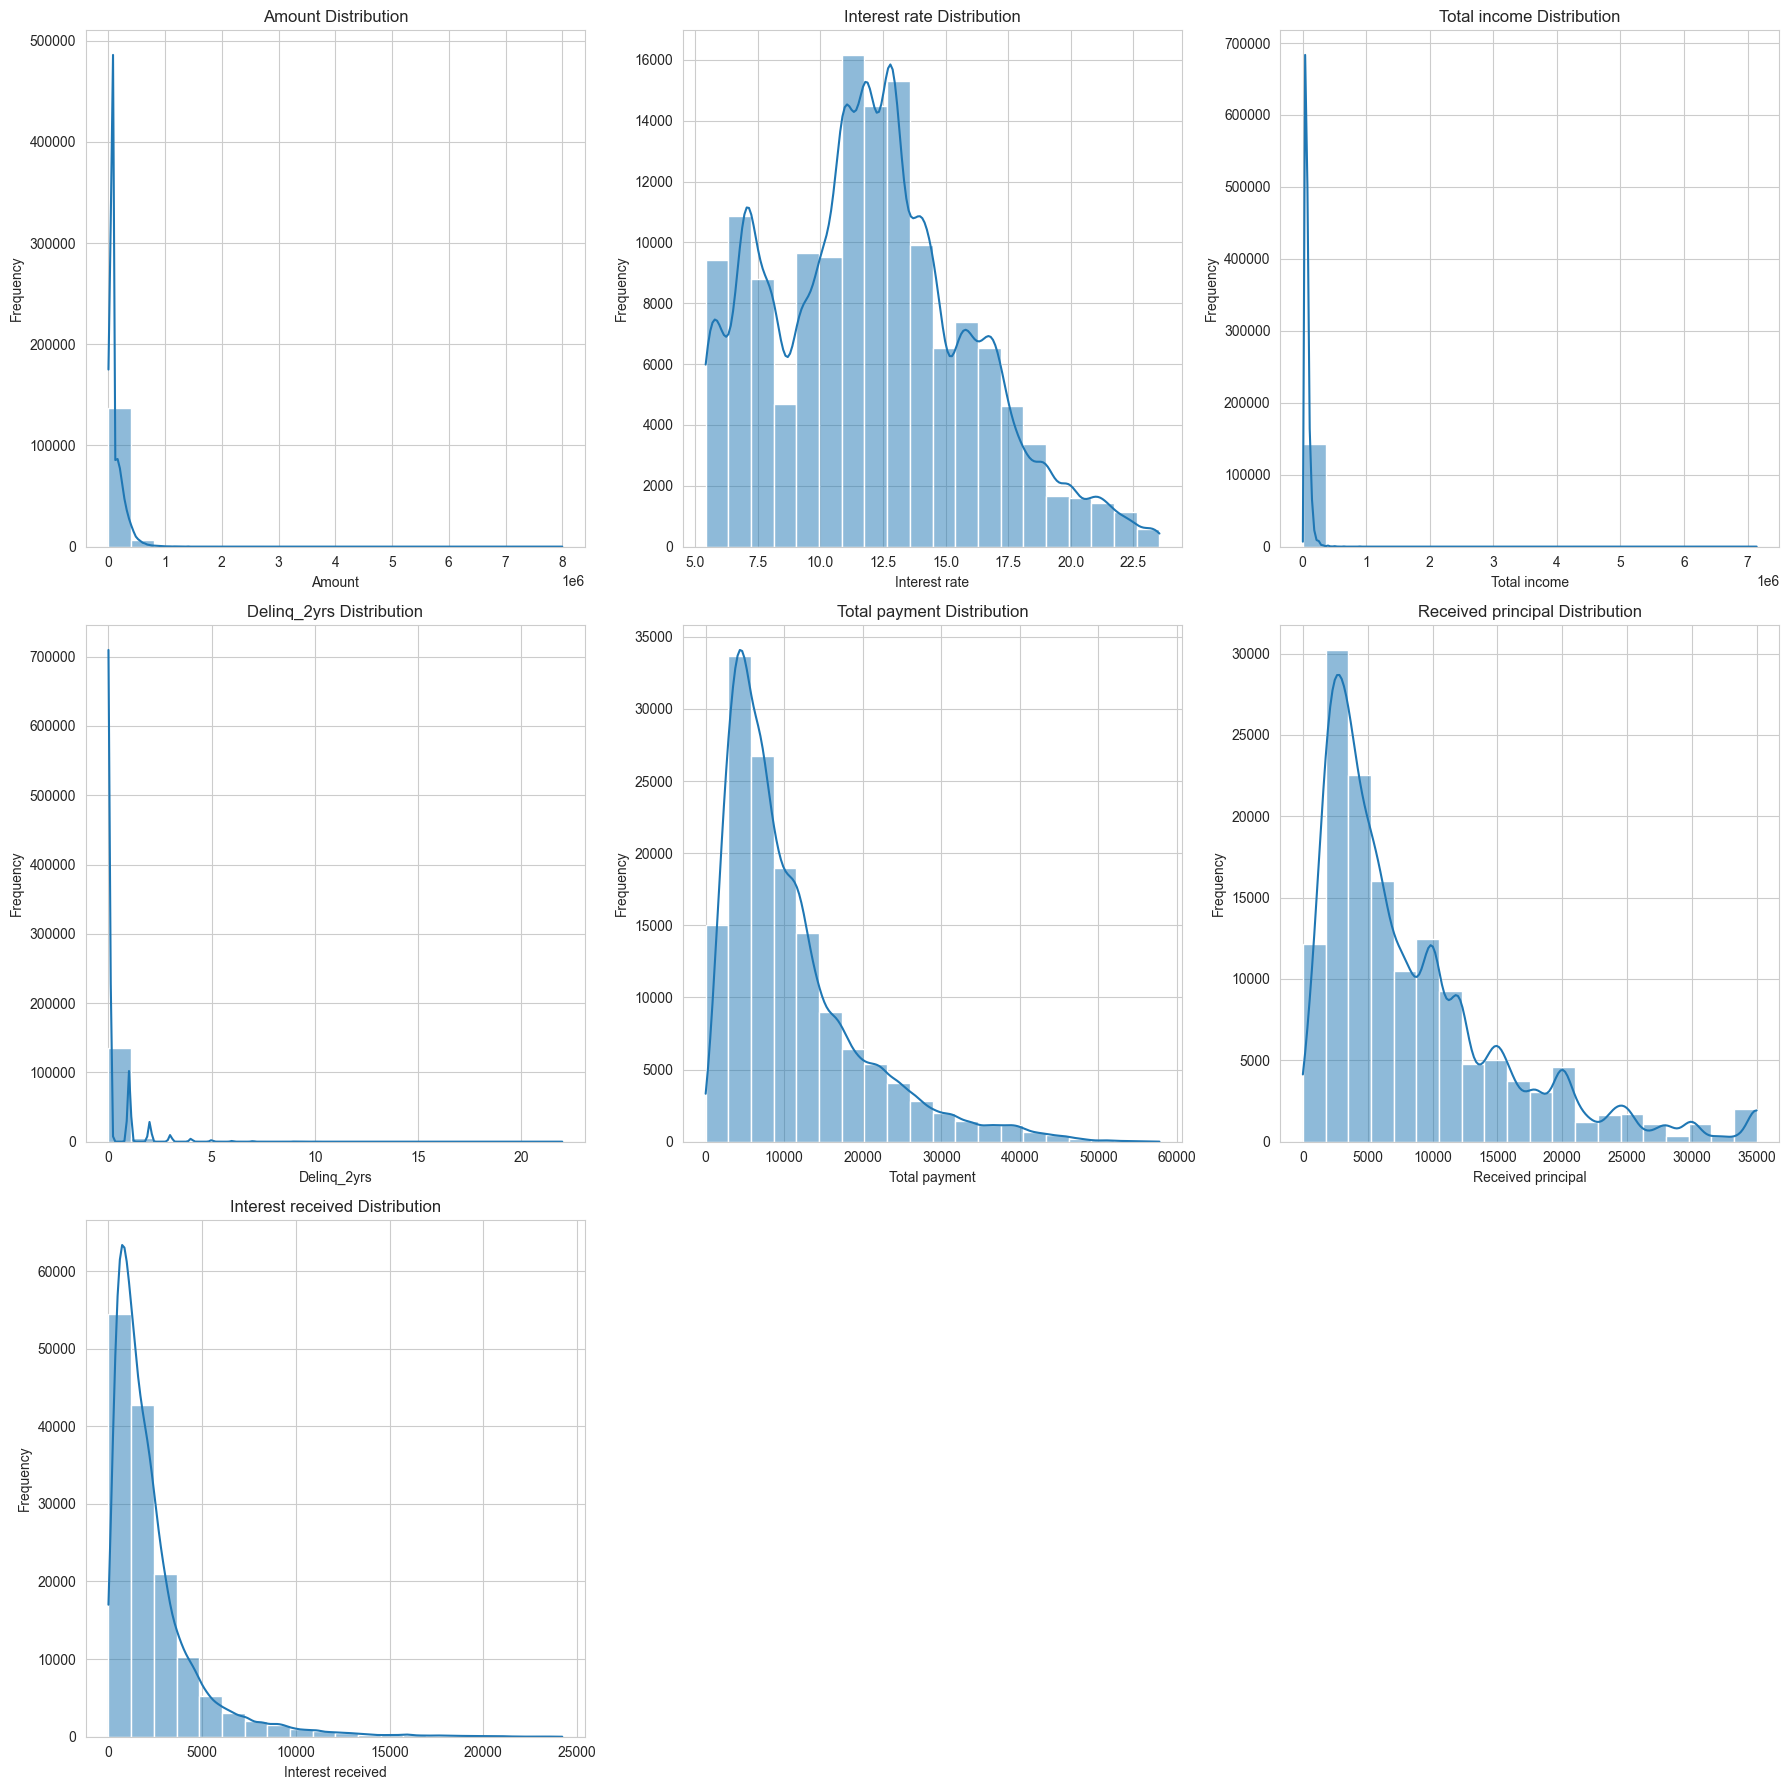

In [19]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

num_features = len(numerical_features)
cols = 3
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axs = axs.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], bins=20, kde=True, ax=axs[i])
    axs[i].set_title(f'{feature.capitalize()} Distribution')
    axs[i].set_xlabel(feature.capitalize())
    axs[i].set_ylabel('Frequency')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Shape Analysis (Skewness)

In [20]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

skewness = df[numerical_features].skew()
print("Skewness of features:\n", skewness)

Skewness of features:
 Amount                 4.878249
Interest Rate          0.357040
Total Income          28.021331
Delinq_2yrs            5.460526
Total Payment          1.567516
Received Principal     1.521783
Interest Received      2.835966
dtype: float64


Highly Skewed Features: Amount,Total Income, Delinq_2yrs, Interest Received
Moderate Skewness: Total Payment, Received Principal

In [21]:
# Apply log transformations
df['Amount'] = np.log1p(df['Amount'])  # First log1p transformation for Amount
df['Total Income'] = np.log1p(df['Total Income'])
df['Interest Received'] = np.log1p(df['Interest Received'])
df['Delinq_2yrs'] = np.log1p(df['Delinq_2yrs'])

# Apply square root transformations for moderately skewed features
df['Total Payment'] = np.sqrt(df['Total Payment'])
df['Received Principal'] = np.sqrt(df['Received Principal'])

# Apply reflection transformation (log with reflection) for negative skewness
df['Interest Received'] = np.log(np.max(df['Interest Received']) - df['Interest Received'] + 1)
df['Amount'] = np.log(np.max(df['Amount']) - df['Amount'] + 1)

# Apply Box-Cox transformation for highly skewed features
Q1 = df['Delinq_2yrs'].quantile(0.25)
Q3 = df['Delinq_2yrs'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = df['Delinq_2yrs'].quantile(0.05)
upper_bound = df['Delinq_2yrs'].quantile(0.95)
df['Delinq_2yrs'] = np.where(df['Delinq_2yrs'] > upper_bound, upper_bound, df['Delinq_2yrs'])
df['Delinq_2yrs'] = np.where(df['Delinq_2yrs'] < lower_bound, lower_bound, df['Delinq_2yrs'])
df['Delinq_2yrs'] = np.log1p(df['Delinq_2yrs'])

In [22]:
skewness = df[numerical_features].skew()
print("Skewness of features:\n", skewness)

Skewness of features:
 Amount               -0.116427
Interest Rate         0.357040
Total Income          0.218395
Delinq_2yrs           1.855522
Total Payment         0.683249
Received Principal    0.669793
Interest Received    -0.487019
dtype: float64


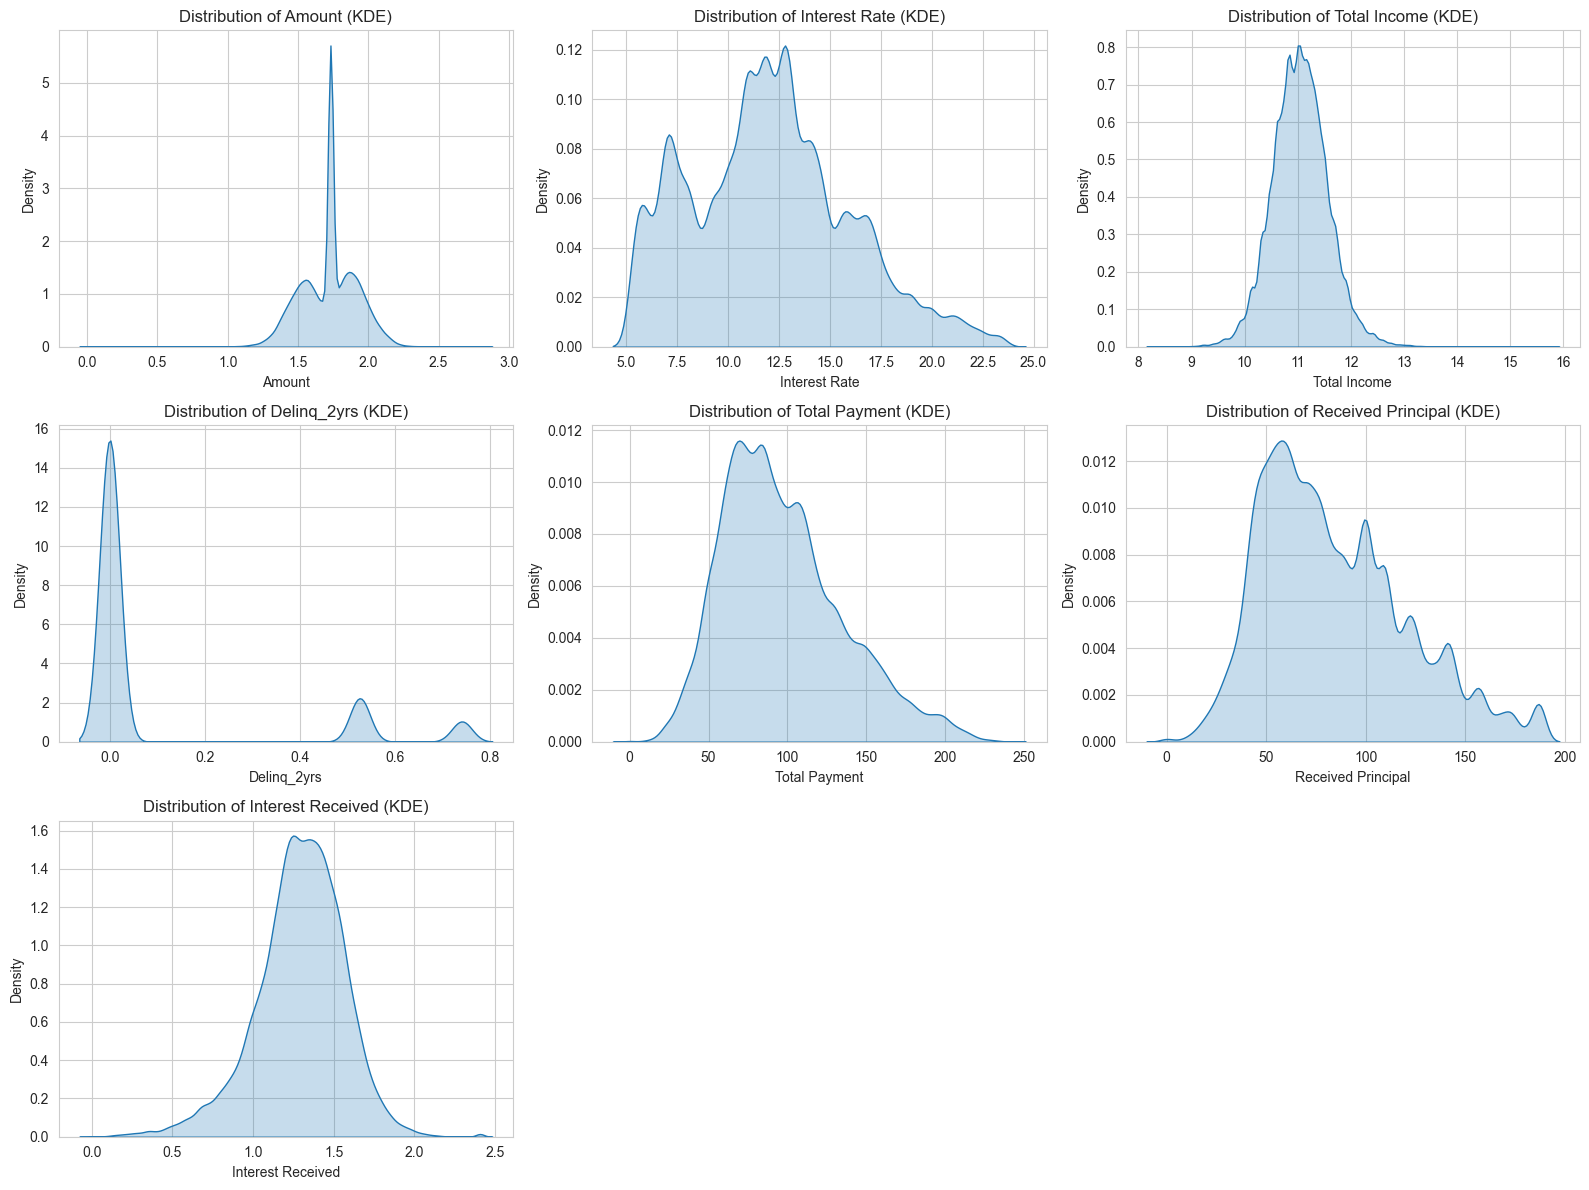

In [23]:
cols = 3
num_features = len(numerical_features)
rows = (num_features // cols) + 1 if num_features % cols != 0 else num_features // cols
plt.figure(figsize=(16, 4 * rows))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(df[feature], shade=True)
    plt.title(f'Distribution of {feature} (KDE)')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Outlier Analysis

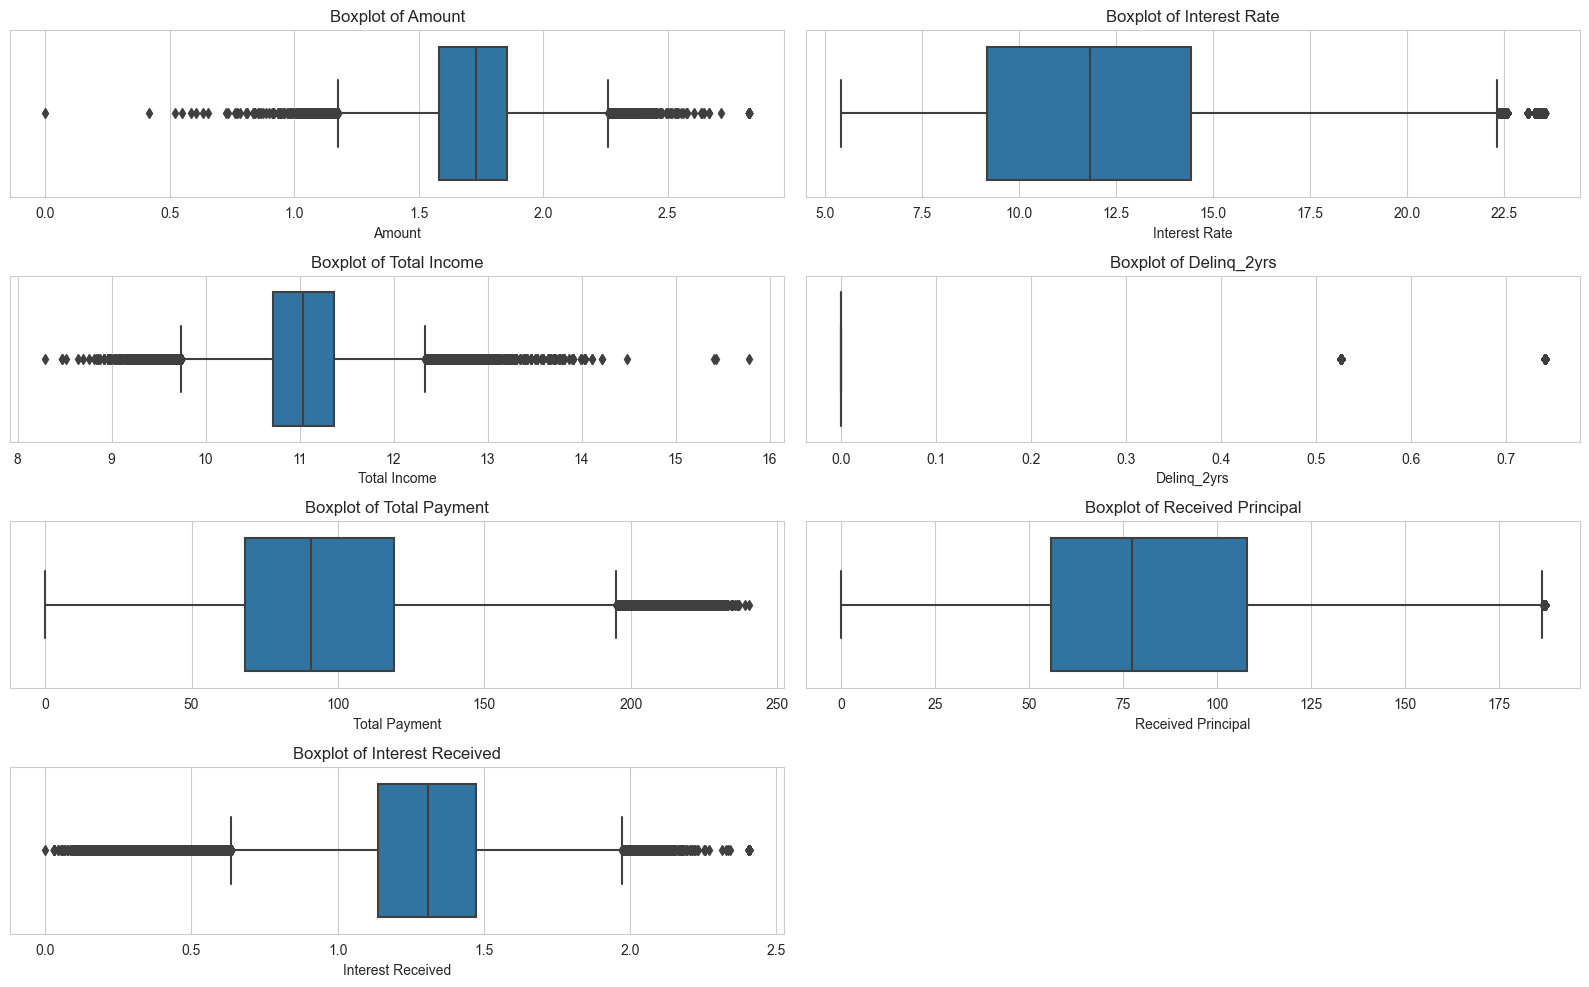

In [24]:
plt.figure(figsize=(16, 12))
for i, feature in enumerate(['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received'], 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [25]:
def calculate_iqr_bounds(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

for feature in ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']:
    lower, upper = calculate_iqr_bounds(df, feature)
    print(f"{feature} has bounds - Lower Bound: {lower}, Upper Bound: {upper}")

Amount has bounds - Lower Bound: 1.175160107965279, Upper Bound: 2.2615105568038385
Interest Rate has bounds - Lower Bound: 1.29, Upper Bound: 22.33
Total Income has bounds - Lower Bound: 9.742928672206894, Upper Bound: 12.333625521595891
Delinq_2yrs has bounds - Lower Bound: 0.0, Upper Bound: 0.0
Total Payment has bounds - Lower Bound: -7.662246255468176, Upper Bound: 195.0966138176517
Received Principal has bounds - Lower Bound: -22.71506176343709, Upper Bound: 186.43174028986212
Interest Received has bounds - Lower Bound: 0.6365776438492543, Upper Bound: 1.9731968319571256


In [26]:
def cap_outliers(df, column, lower_bound, upper_bound):
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

def remove_negative_values(df, columns):
    for column in columns:
        df = df[df[column] >= 0]
    return df

bounds = {
    'Amount': (1.175160107965279, 2.2615105568038385),
    'Total Income': (9.742928672206894, 12.333625521595891),
    'Total Payment': (0, 195.0966138176517),
    'Received Principal': (0, 186.43174028986212),
    'Interest Received': (0.6365776438492543, 1.9731968319571256)
}

capping_features = list(bounds.keys())
features_with_invalid_negatives = ['Total Payment', 'Received Principal']

def outlier_handling(df, capping_features, bounds, features_with_invalid_negatives):
    df = remove_negative_values(df, features_with_invalid_negatives)
    
    for feature in capping_features:
        lower_bound, upper_bound = bounds[feature]
        df = cap_outliers(df, feature, lower_bound, upper_bound)
    
    return df

df = outlier_handling(df, capping_features, bounds, features_with_invalid_negatives)

In [27]:
df[numerical_features].describe()

,Amount,Interest Rate,Total Income,Delinq_2yrs,Total Payment,Received Principal,Interest Received
count,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.721249,12.038703,11.039959,0.103734,96.671791,84.089372,1.292836
std,0.194252,3.880204,0.507444,0.229547,37.729115,36.509769,0.262063
min,1.175160,5.420000,9.742929,0.000000,0.000000,0.000000,0.636578
25%,1.582542,9.180000,10.714440,0.000000,68.372326,55.714989,1.137810
50%,1.731400,11.840000,11.031675,0.000000,90.622348,77.459667,1.307267
75%,1.854129,14.440000,11.362114,0.000000,119.062041,108.001690,1.471965
max,2.261511,23.540000,12.333626,0.741276,195.096614,186.431740,1.973197


## Class Imbalance Analysis

Target Feature Distribution Balance:
Non-default (0): 130258 (90.63%)
Default (1): 13469 (9.37%)


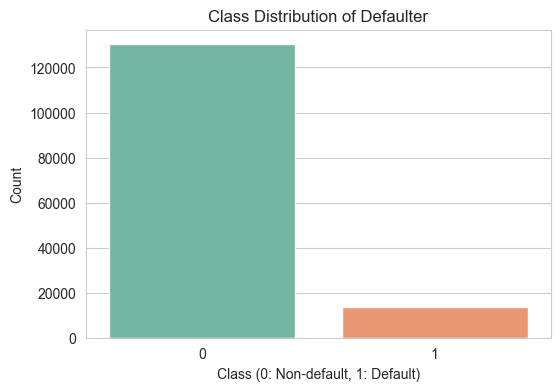

In [28]:
class_counts = df['Defaulter'].value_counts()
class_percentages = class_counts / class_counts.sum() * 100

print("Target Feature Distribution Balance:")
print(f"Non-default (0): {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"Default (1): {class_counts[1]} ({class_percentages[1]:.2f}%)")

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution of Defaulter")
plt.xlabel("Class (0: Non-default, 1: Default)")
plt.ylabel("Count")
plt.show()

The dataset has a significant imbalance, with the non-default class dominating the default class which is common in credit or loan default datasets.

In [29]:
# copy for SMOTE purposes
df_smote = df.copy()
categorical_columns = df_smote.select_dtypes(include=['object', 'category']).columns
# Convert all categorical columns to strings to ensure uniform data types
for column in categorical_columns:
    df_smote[column] = df_smote[column].astype(str)

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df_smote[column] = label_encoders[column].fit_transform(df_smote[column])

X_smote = df_smote.drop('Defaulter', axis=1)  # Features
y_smote = df_smote['Defaulter']  # Target

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
Defaulter
1    130258
0    130258
Name: count, dtype: int64


## Binvariate Analysis

### Numerical Features Correlation analysis

Pearson Correlation Matrix:
                      Amount  Interest Rate  Total Income  Delinq_2yrs  \
Amount              1.000000       0.067822     -0.472455    -0.089013   
Interest Rate       0.067822       1.000000     -0.067585     0.069311   
Total Income       -0.472455      -0.067585      1.000000     0.093780   
Delinq_2yrs        -0.089013       0.069311      0.093780     1.000000   
Total Payment      -0.196090       0.176565      0.359840    -0.030902   
Received Principal -0.170252       0.024338      0.325349    -0.043525   
Interest Received   0.178215      -0.487585     -0.295583    -0.023277   

                    Total Payment  Received Principal  Interest Received  
Amount                  -0.196090           -0.170252           0.178215  
Interest Rate            0.176565            0.024338          -0.487585  
Total Income             0.359840            0.325349          -0.295583  
Delinq_2yrs             -0.030902           -0.043525          -0.023277  
Tota

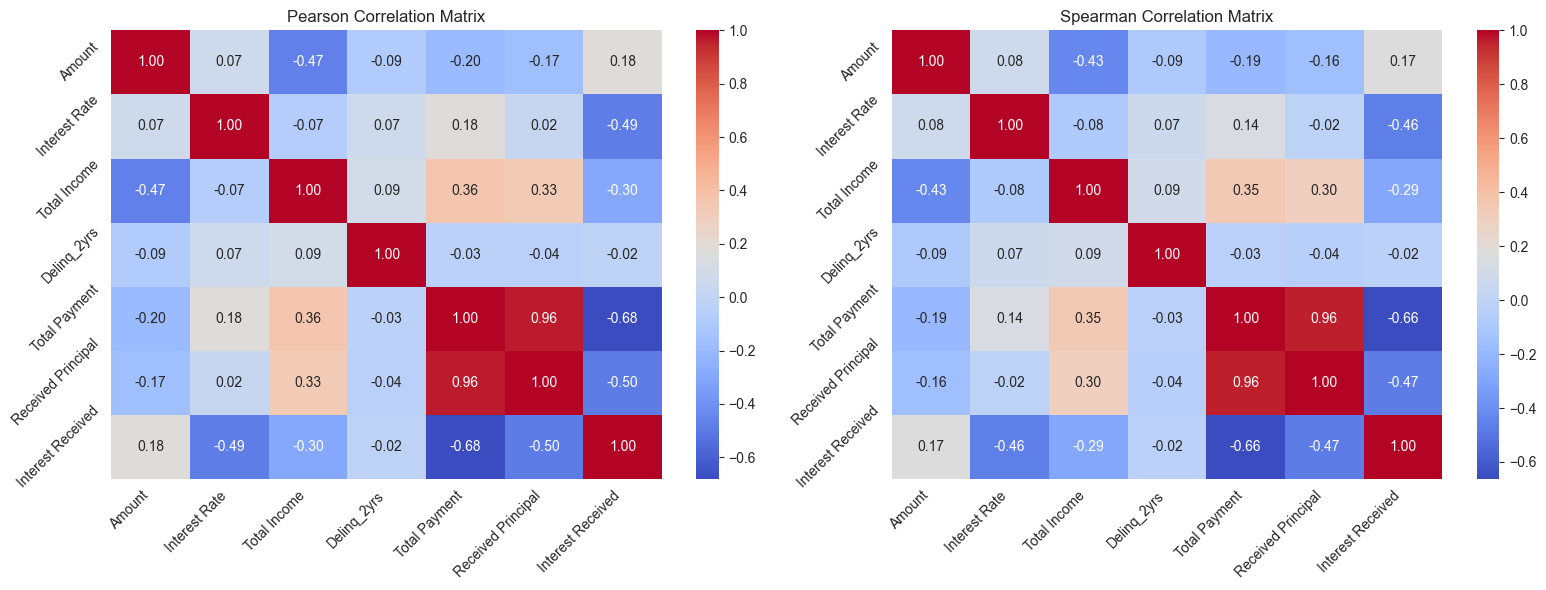

In [30]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

numerical_df = df[numerical_features]
pearson_corr_matrix = numerical_df.corr(method='pearson')
spearman_corr_matrix = numerical_df.corr(method='spearman')

print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

print("\nSpearman Correlation Matrix:")
print(spearman_corr_matrix)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson Correlation Heatmap
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45)

# Spearman Correlation Heatmap
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Amount vs. Total Income: High negative correlation. This indicates that as Total Income increases, the loan Amount tends to decrease.

Interest Rate vs. Interest Received: Strong negative correlation. Higher Interest Rate results in lower Interest Received, possibly because higher interest rates might discourage larger loans or longer terms.

Total Payment vs. Received Principal: Very high positive correlation. Received Principal makes up a large portion of Total Payment.

Total Payment vs. Interest Received: Strong negative correlation. As Interest Received increases, Total Payment decreases, possibly due to the structure of the loan and its repayment terms.

Linear vs. Monotonic Relationships: In most cases, the Pearson and Spearman correlations are similar in sign and magnitude, suggesting that the relationships between features are both linear and monotonic. This consistency suggests the relationships can be captured well by both linear models and tree-based models.

Pearson Correlation with Target:
Amount                0.031327
Interest Rate         0.169082
Total Income         -0.060564
Delinq_2yrs          -0.015765
Total Payment        -0.165847
Received Principal   -0.246399
Interest Received     0.021868
Name: Defaulter, dtype: float64

Spearman Correlation with Target:
Amount                0.027413
Interest Rate         0.165307
Total Income         -0.061563
Delinq_2yrs          -0.015480
Total Payment        -0.165265
Received Principal   -0.253068
Interest Received     0.023361
Name: Defaulter, dtype: float64


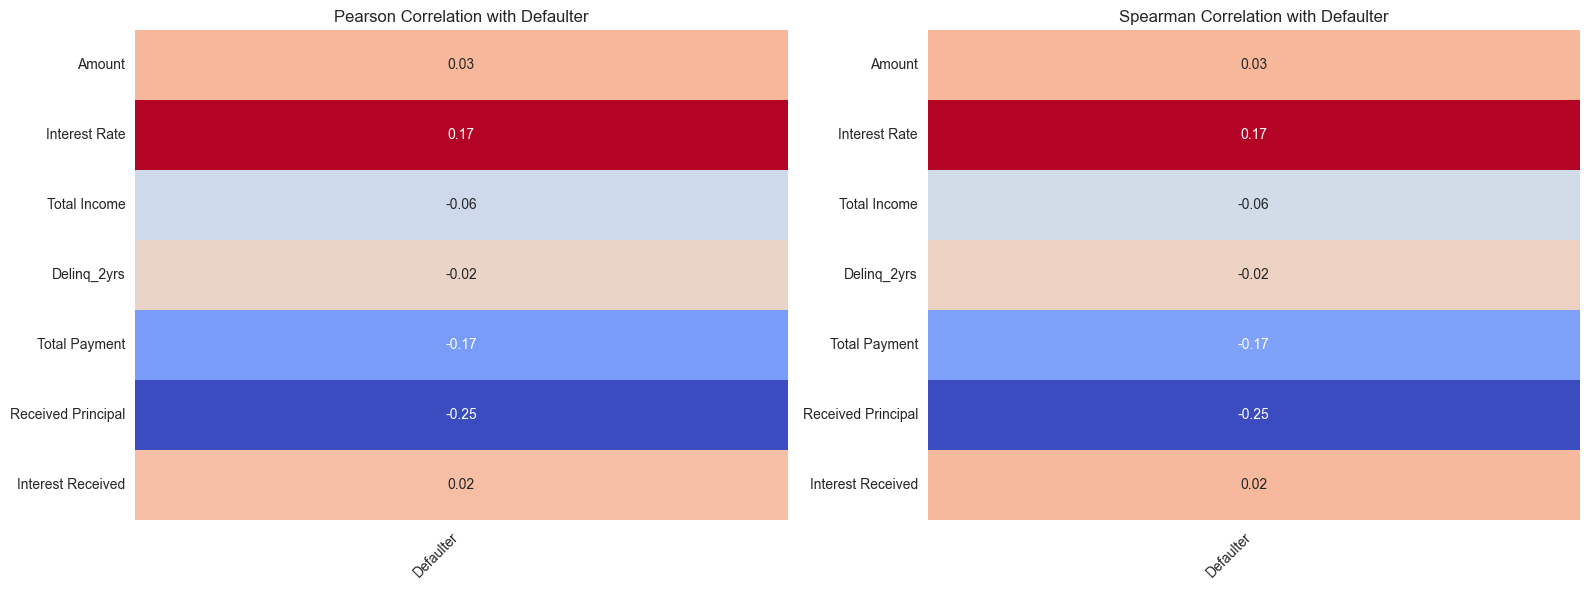

In [31]:
# Define numerical features and target
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']
numerical_df = df[numerical_features + ['Defaulter']]

# Compute Pearson and Spearman correlations with the target (Defaulter)
pearson_corr_with_target = numerical_df.corr(method='pearson')['Defaulter'].drop('Defaulter')
spearman_corr_with_target = numerical_df.corr(method='spearman')['Defaulter'].drop('Defaulter')

print("Pearson Correlation with Target:")
print(pearson_corr_with_target)

print("\nSpearman Correlation with Target:")
print(spearman_corr_with_target)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson Correlation heatmap
sns.heatmap(pearson_corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0], cbar=False)
axes[0].set_title('Pearson Correlation with Defaulter')
axes[0].set_xticklabels(['Defaulter'], rotation=45, ha='right')
axes[0].set_yticklabels(pearson_corr_with_target.index, rotation=0)

# Spearman Correlation heatmap
sns.heatmap(spearman_corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1], cbar=False)
axes[1].set_title('Spearman Correlation with Defaulter')
axes[1].set_xticklabels(['Defaulter'], rotation=45, ha='right')
axes[1].set_yticklabels(spearman_corr_with_target.index, rotation=0)

plt.tight_layout()
plt.show()

Received Principal has a moderate negative correlation with the target. This suggests that a higher Received Principal is associated with a lower likelihood of default. Borrowers who repay more of the principal amount tend to have a lower chance of default.

Total Payment has a negative correlation with the target, implying that borrowers who have made higher total payments are less likely to default.

## Multicollinearity Check (VIF)

In [32]:
X = df[numerical_features].assign(const=1)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

              Feature          VIF
0              Amount     1.305110
1       Interest Rate     1.627341
2        Total Income     1.486142
3         Delinq_2yrs     1.027047
4       Total Payment    65.038492
5  Received Principal    47.146219
6   Interest Received     5.715856
7               const  1324.047447


VIF > 10: Indicates high multicollinearity 
VIF > 5: Indicates moderate multicollinearity
VIF < 1.5: Indicates low multicollinearity, which is acceptable

Total Payment and Received Principal have very high VIF values, indicating strong multicollinearity supported by the previous correlation matrix analysis. The next step is to combine them into a new feature `Payment_to_Principal_Ratio`

## Feature Engineering and Selection

In [33]:
df['Payment_to_Principal_Ratio'] = df['Total Payment'] / (df['Received Principal'] + 1)
df = df.drop(columns=['Total Payment', 'Received Principal'])

The newly created feature, `Payment_to_Principal_Ratio`, should capture the relevant information from both Total Payment and Received Principal, reducing redundancy in the model.

In [34]:
numerical_df = df.select_dtypes(include=[np.number])
numerical_df['const'] = 1

vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_df.columns

vif_data['VIF'] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]
print(vif_data)

                      Feature          VIF
0                      Amount     1.302498
1               Interest Rate     1.445164
2                Total Income     1.433412
3                 Delinq_2yrs     1.021226
4           Interest Received     1.550293
5  Payment_to_Principal_Ratio     1.014926
6                       const  1195.491255


### Categorical Features Chi-Square Test

In [43]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type', 
                        'Tier of Employment', 'Work Experience', 'Gender', 
                        'Married', 'Dependents', 'Home', 'Social Profile', 
                        'Is_verified', 'Number of loans']
target_variable = 'Defaulter'

df[categorical_features + [target_variable]] = df[categorical_features + [target_variable]].astype(str)
chi2_results = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'p-value', 'Test Statistic', 'Degrees of Freedom'])

for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        feature1 = categorical_features[i]
        feature2 = categorical_features[j]
        
        contingency_table = pd.crosstab(df[feature1], df[feature2])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        
        temp_df = pd.DataFrame({
            'Feature 1': [feature1],
            'Feature 2': [feature2],
            'p-value': [p],
            'Test Statistic': [chi2],
            'Degrees of Freedom': [dof]
        })
        chi2_results = pd.concat([chi2_results, temp_df], ignore_index=True)

print("Chi-square test between all pairs of features:")
chi2_results

Chi-square test between all pairs of features:


,Feature 1,Feature 2,p-value,Test Statistic,Degrees of Freedom
0,Loan Category,Loan Tenure,4.064223e-232,1089.417090,6
1,Loan Category,Employment type,6.894245e-33,164.408429,6
2,Loan Category,Tier of Employment,3.773445e-273,1410.586939,36
3,Loan Category,Work Experience,1.839875e-301,1566.864636,42
4,Loan Category,Gender,1.139944e-02,25.815030,12
...,...,...,...,...,...
61,Home,Is_verified,5.356346e-01,7.009254,8
62,Home,Number of loans,9.867352e-01,6.120975,16
63,Social Profile,Is_verified,2.186715e-03,12.250710,2
64,Social Profile,Number of loans,2.760081e-01,5.111893,4


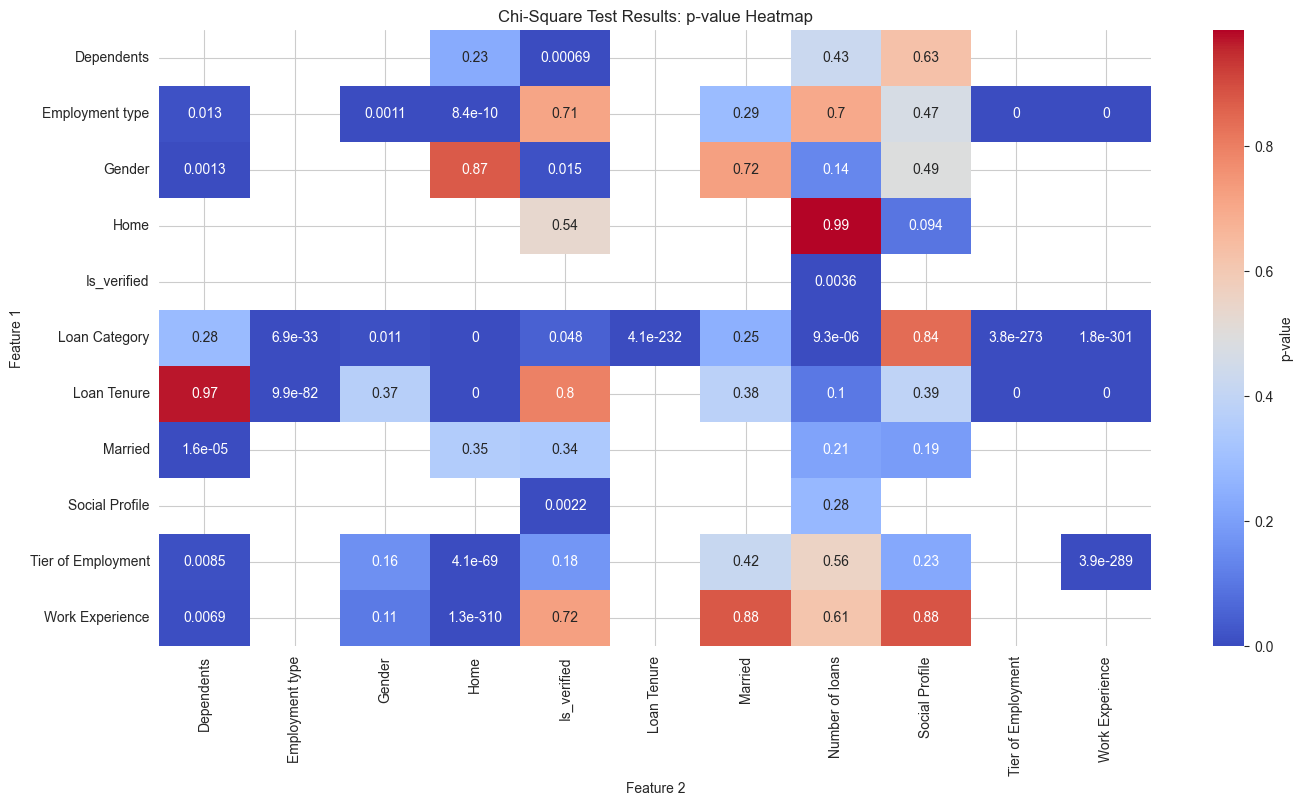

In [48]:
heatmap_data = chi2_results.pivot(index="Feature 1", columns="Feature 2", values="p-value")
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'p-value'})
plt.title('Chi-Square Test Results: p-value Heatmap')
plt.show()

Pairs with very low p-values suggest strong associations, meaning these features are likely correlated
Pairs with higher p-values suggest that the features are likely independent. 

Loan category (e.g., consolidation, credit card, home) is significantly correlated with other employment-related features. For example, individuals with certain loan types may tend to fall into specific employment categories or have certain work experience ranges.

Employment type (whether a person is salaried or self-employed) is highly correlated with the tier of employment and work experience. This makes sense because people in higher-tier employment are likely to have more work experience, and salaried employees might dominate certain tiers.

Loan tenure (the loan duration) shows a strong relationship with verification status and the number of loans. This could indicate that longer-tenure loans tend to go through more rigorous verification processes, or borrowers with multiple loans have shorter tenures.

Work Experience shows a strong correlation with Employment Type and Tier of Employment as those with more experience tend to hold higher-tier employment roles.

In [50]:
chi2_results_target = pd.DataFrame(columns=['Feature', 'p-value', 'Test Statistic', 'Degrees of Freedom'])

# Chi-square test between each feature and the target variable
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df[target_variable])
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    temp_df = pd.DataFrame({
        'Feature': [feature],
        'p-value': [p],
        'Test Statistic': [chi2],
        'Degrees of Freedom': [dof]
    })
    chi2_results_target = pd.concat([chi2_results_target, temp_df], ignore_index=True)

print("\nChi-square test between each feature and the target variable:")
chi2_results_target


Chi-square test between each feature and the target variable:


,Feature,p-value,Test Statistic,Degrees of Freedom
0,Loan Category,3.343784e-126,599.274583,6
1,Loan Tenure,1.001395e-33,146.515688,1
2,Employment type,6.293559e-90,404.327539,1
3,Tier of Employment,0.000000e+00,1515.629942,6
4,Work Experience,0.000000e+00,4825.193895,7
5,Gender,6.115570e-01,0.983494,2
6,Married,9.027276e-01,0.014937,1
7,Dependents,3.418652e-02,10.401128,4
8,Home,3.083836e-43,205.049592,4
9,Social Profile,2.589808e-01,1.274197,1


Strong relationship between features and target feature:

Loan categories (e.g., consolidation, credit card, home) significantly impact the likelihood of default. Borrowers with certain loan types may be more or less likely to default, which aligns with different risk profiles for various loan categories.

The length of time over which a loan is repaid (eg: short-term vs. long-term loans) is also significantly associated with default risk. Long-term loans might carry higher risk.

Employment type (salaried vs. self-employed) has a significant impact on default rates. Self-employed individuals may be more prone to default due to potentially unstable income.

The employment tier (e.g., lower-tier vs. higher-tier jobs) is highly related to default risk. Borrowers in lower employment tiers may struggle more with repayment.

Work experience is strongly correlated with default risk. Borrowers with less work experience (e.g., early career individuals) might be at a higher risk of default compared to those with more experience.

The number of dependents a borrower has impacts their likelihood of default. Individuals with more dependents may have higher financial obligations, increasing the default risk.

 Whether the borrower owns a home is significantly associated with the likelihood of default. Homeowners may have more assets and stability, which could reduce their default risk.

## Feature Engineering and Selection

gender is not a significant feature as it does not have a strong relationship with the target features and can be dropped.
married is also not a significant features in relation to the target and additionally may be redundant as that information may be captured in the dependents feature.

In [ ]:
columns_to_drop = ['Gender', 'Married']
df = df.drop(columns=columns_to_drop)

## Categorical and Numerical Features ANOVA

Current state of dataset after feature engineering and selection based on numerical and categorical feature analysis.

In [62]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical Features:")
print(categorical_features)

numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical Features:")
print(numerical_features)


Categorical Features:
['Loan Category', 'Loan Tenure', 'Employment type', 'Tier of Employment', 'Work Experience', 'Dependents', 'Home', 'Social Profile', 'Is_verified', 'Number of loans', 'Defaulter']

Numerical Features:
['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Interest Received', 'Payment_to_Principal_Ratio']


In [64]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type', 'Tier of Employment', 'Work Experience', 'Dependents', 'Home', 'Social Profile', 'Is_verified', 'Number of loans', 'Defaulter']
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Interest Received', 'Payment_to_Principal_Ratio']

anova_results = []

for cat_feature in categorical_features:
    for num_feature in numerical_features:
        groups = [df[df[cat_feature] == category][num_feature].dropna() for category in df[cat_feature].unique()]
        
        # Perform the ANOVA
        f_stat, p_value = f_oneway(*groups)
        
        anova_results.append({
            'Categorical Feature': cat_feature,
            'Numerical Feature': num_feature,
            'F-Statistic': f_stat,
            'p-value': p_value
        })

anova_df = pd.DataFrame(anova_results)

grouped_anova = anova_df.groupby('Categorical Feature')

for cat_feature, group in grouped_anova:
    print(f"\nCategorical Feature: {cat_feature}")
    print(group[['Numerical Feature', 'F-Statistic', 'p-value']].to_string(index=False))


Categorical Feature: Defaulter
         Numerical Feature  F-Statistic       p-value
                    Amount   141.185147  1.518161e-32
             Interest Rate  4229.826211  0.000000e+00
              Total Income   529.115612 7.163474e-117
               Delinq_2yrs    35.730749  2.270911e-09
         Interest Received    68.766124  1.118026e-16
Payment_to_Principal_Ratio  3045.272051  0.000000e+00

Categorical Feature: Dependents
         Numerical Feature  F-Statistic  p-value
                    Amount     1.877043 0.111356
             Interest Rate     0.325521 0.861022
              Total Income     1.411515 0.227192
               Delinq_2yrs     0.499973 0.735779
         Interest Received     0.793533 0.529121
Payment_to_Principal_Ratio     1.874283 0.111842

Categorical Feature: Employment type
         Numerical Feature  F-Statistic       p-value
                    Amount    32.668296  1.095210e-08
             Interest Rate    64.077783  1.204864e-15
              

In [36]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type', 
                        'Tier of Employment', 'Work Experience', 'Gender', 
                        'Married', 'Dependents', 'Home', 'Social Profile', 
                        'Is_verified', 'Number of loans']

chi2_results = pd.DataFrame(columns=['Feature', 'p-value', 'Test Statistic', 'Degrees of Freedom'])

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Defaulter'])
    
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    
    chi2_results = chi2_results.append({
        'Feature': feature,
        'p-value': p,
        'Test Statistic': chi2,
        'Degrees of Freedom': dof
    }, ignore_index=True)

print(chi2_results)

AttributeError: scipy.stats.stats is deprecated and has no attribute chi2_contingency. Try looking in scipy.stats instead.

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Check for binary numerical features (which should be treated as categorical)
binary_categorical_columns = [col for col in numerical_columns if df[col].nunique() == 2]

# Explicitly add 'Work Experience Encoded' and 'Dependents' to the categorical list
categorical_columns += binary_categorical_columns + ['Dependents']

# Remove 'Work Experience Encoded' and 'Dependents' from numerical columns
numerical_columns = [col for col in numerical_columns if col not in binary_categorical_columns + ['Work Experience Encoded', 'Dependents']]

# Get unique values for categorical columns
unique_values_categorical = {col: df[col].unique() for col in categorical_columns}

# Print the categorical columns and their unique values
print("Categorical Features and Unique Values:")
for col, unique_values in unique_values_categorical.items():
    print(f"{col}: {unique_values}")

# Print the remaining numerical columns
print("\nNumerical Features:")
print(numerical_columns)

In [ ]:
null_values = df.isnull().sum()
print(null_values[null_values > 0])

In [ ]:
df['Amount Missing'] = df['Amount'].isnull().astype(int)
df['Amount'].fillna(df['Amount'].median(), inplace=True)

In [ ]:
df = df.dropna(subset=['Work Experience'])
target_encoder = ce.TargetEncoder(cols=['Work Experience'])
df['Work Experience Encoded'] = target_encoder.fit_transform(df['Work Experience'], df['Defaulter'])

In [ ]:
replace_with = 'Unknown'
columns_to_replace = ['Social Profile', 'Is_verified', 'Married', 'Employment type']
df[columns_to_replace] = df[columns_to_replace].fillna(replace_with)
df['Tier of Employment'].fillna('X', inplace=True)

In [ ]:
null_values = df.isnull().sum()
print(null_values[null_values > 0])

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Check for binary numerical features (which should be treated as categorical)
binary_categorical_columns = [col for col in numerical_columns if df[col].nunique() == 2]

# Explicitly add 'Work Experience Encoded' and 'Dependents' to the categorical list
categorical_columns += binary_categorical_columns + ['Work Experience Encoded', 'Dependents']

# Remove 'Work Experience Encoded' and 'Dependents' from numerical columns
numerical_columns = [col for col in numerical_columns if col not in binary_categorical_columns + ['Work Experience Encoded', 'Dependents']]

# Get unique values for categorical columns
unique_values_categorical = {col: df[col].unique() for col in categorical_columns}

# Print the categorical columns and their unique values
print("Categorical Features and Unique Values:")
for col, unique_values in unique_values_categorical.items():
    print(f"{col}: {unique_values}")

# Print the remaining numerical columns
print("\nNumerical Features:")
print(numerical_columns)

In [ ]:
df.head()

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Check for binary numerical features (which should be treated as categorical)
binary_categorical_columns = [col for col in numerical_columns if df[col].nunique() == 2]

# Explicitly add 'Work Experience Encoded' and 'Dependents' to the categorical list
categorical_columns += binary_categorical_columns + ['Work Experience Encoded', 'Dependents']

# Remove 'Work Experience Encoded' and 'Dependents' from numerical columns
numerical_columns = [col for col in numerical_columns if col not in binary_categorical_columns + ['Work Experience Encoded', 'Dependents']]

# Calculate skewness for the remaining numerical columns
skewness_metrics = df[numerical_columns].skew()

# Print skewness metrics
print("Skewness Metrics for Numerical Columns:")
print(skewness_metrics)

for feature in numerical_columns:
    print(f"\n{feature} (skewness: {skewness_metrics[feature]:.2f})")

    # Create subplots for histogram and KDE plot
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot histogram with kernel density estimate (KDE)
    sns.histplot(df[feature], kde=True, color='blue', ax=axes[0])
    axes[0].set_title(f'{feature} - Histogram')

    # Plot KDE (Kernel Density Estimate)
    sns.kdeplot(df[feature], color='blue', ax=axes[1])
    axes[1].set_title(f'{feature} - KDE')

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

In [ ]:
# Apply log and sqrt transformations where applicable based on skewness
df['Amount'] = np.log1p(df['Amount'])  # log(Amount + 1) to handle 0 values
df['Total Income'] = np.log1p(df['Total Income'])
df['Delinq_2yrs'] = np.log1p(df['Delinq_2yrs'])
df['Interest Received'] = np.log1p(df['Interest Received'])
df['Number of loans'] = np.log1p(df['Number of loans'])

df['Total Payment'] = np.sqrt(df['Total Payment'])
df['Received Principal'] = np.sqrt(df['Received Principal'])

# Recalculate skewness metrics for transformed columns
transformed_columns = ['Amount', 'Total Income', 'Delinq_2yrs', 'Interest Received', 'Number of loans', 'Total Payment', 'Received Principal']

transformed_skewness_metrics = df[transformed_columns].skew()

# Output the skewness metrics
print("Skewness Metrics for Transformed Columns:")
print(transformed_skewness_metrics)

for feature in transformed_columns:
    print(f"\n{feature} (skewness: {skewness_metrics[feature]:.2f})")

    # Create subplots for histogram and KDE plot
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot histogram with kernel density estimate (KDE)
    sns.histplot(df[feature], kde=True, color='blue', ax=axes[0])
    axes[0].set_title(f'{feature} - Histogram')

    # Plot KDE (Kernel Density Estimate)
    sns.kdeplot(df[feature], color='blue', ax=axes[1])
    axes[1].set_title(f'{feature} - KDE')

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

In [ ]:
def detect_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detect outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"Outliers in '{column}':")
    print(outliers[[column]])

    # Optionally, visualize the outliers using a boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f"Outliers in {column}")
    plt.show()

    return outliers

# Function to cap values at the 95th percentile
def cap_values(df, column):
    cap_value = df[column].quantile(0.95)
    df[f'{column}_capped'] = np.where(df[column] > cap_value, cap_value, df[column])
    return df

# Function to check and print skewness
def check_skewness(df, columns):
    skewness_metrics = df[columns].skew()
    print("Skewness Metrics:")
    print(skewness_metrics)
    return skewness_metrics

# Function to apply transformations and visualize results
def apply_log_and_boxcox(df, column):
    # Log transformation
    df[f'{column}_log'] = np.log1p(df[column])  # log(x + 1) to handle 0 values
    log_skewness = df[f'{column}_log'].skew()
    print(f"Skewness after log transformation for {column}: {log_skewness}")
    
    # Visualize log-transformed data
    plt.figure(figsize=(10, 5))
    sns.histplot(df[f'{column}_log'], kde=True, color='blue')
    plt.title(f'{column}_log - Histogram and KDE after Log Transformation')
    plt.show()
    
    # Box-Cox transformation
    df[f'{column}_boxcox'], fitted_lambda = stats.boxcox(df[column] + 1e-6)  # Small constant to avoid log(0)
    boxcox_skewness = pd.Series(df[f'{column}_boxcox']).skew()
    print(f"Skewness after Box-Cox transformation for {column}: {boxcox_skewness}")
    
    # Visualize Box-Cox transformed data
    plt.figure(figsize=(10, 5))
    sns.histplot(df[f'{column}_boxcox'], kde=True, color='blue')
    plt.title(f'{column}_boxcox - Histogram and KDE after Box-Cox Transformation')
    plt.show()

    return df

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 1: Detect outliers for "Number of loans" and "Delinq_2yrs"
outliers_number_of_loans = detect_outliers_iqr(df, 'Number of loans')
outliers_delinq_2yrs = detect_outliers_iqr(df, 'Delinq_2yrs')

# Step 2: Cap the values at the 95th percentile
df = cap_values(df, 'Number of loans')
df = cap_values(df, 'Delinq_2yrs')

# Step 3: Check skewness of capped columns
capped_columns = ['Number of loans_capped', 'Delinq_2yrs_capped']
check_skewness(df, capped_columns)

# Visualize capped features
for feature in capped_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True, color='blue')
    plt.title(f'{feature} - Histogram and KDE after Capping')
    plt.show()

# Step 4: Apply transformations (Log and Box-Cox) for 'Delinq_2yrs_capped'
df = apply_log_and_boxcox(df, 'Delinq_2yrs_capped')

In [ ]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the Pearson and Spearman correlation matrices
pearson_corr_matrix = numerical_df.corr(method='pearson')
spearman_corr_matrix = numerical_df.corr(method='spearman')

# Print the Pearson and Spearman correlation matrices
print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

print("\nSpearman Correlation Matrix:")
print(spearman_corr_matrix)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'Defaulter' is your target variable
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Defaulter'])
plt.title('Class Distribution of Defaulter')
plt.show()

# Print the class distribution
class_distribution = df['Defaulter'].value_counts()
print(class_distribution)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Copy the original dataframe to avoid altering the original one
df_encoded = df.copy()

# Label Encoding for ordinal categorical features
ordinal_features = ['Tier of Employment', 'Work Experience Encoded', 'Dependents']

# Apply LabelEncoder to ordinal features
label_encoders = {}
for feature in ordinal_features:
    le = LabelEncoder()
    df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))  # Convert to string to handle NaNs
    label_encoders[feature] = le

# One-Hot Encoding for nominal categorical features
nominal_features = ['Loan Category', 'Employment type', 'Gender', 'Married', 'Home', 'Social Profile', 'Is_verified']

# Apply OneHotEncoder to nominal features
df_encoded = pd.get_dummies(df_encoded, columns=nominal_features, drop_first=True)
le_work_exp = LabelEncoder()
df_encoded['Work Experience'] = le_work_exp.fit_transform(df_encoded['Work Experience'].astype(str))
# Print the encoded dataframe
print("Encoded Dataframe Head:")
print(df_encoded.head())

In [ ]:
from imblearn.combine import SMOTETomek

# Separate features and target variable
X = df_encoded.drop('Defaulter', axis=1)
y = df_encoded['Defaulter']

# Apply SMOTETomek for resampling
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Check new class distribution
print("Class distribution after SMOTE-Tomek:")
print(pd.Series(y_resampled).value_counts())

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 1. Regularized Decision Tree Classifier
dt_model = DecisionTreeClassifier(
    random_state=42, 
    max_depth=10,                 # Limiting the maximum depth
    min_samples_split=10,         # Minimum samples required to split an internal node
    min_samples_leaf=5            # Minimum samples required to be at a leaf node
)
dt_model.fit(X_train, y_train)

# Predictions on both training and test data
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Evaluation on training data
print("Decision Tree Classifier (Train) Report:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}")

# Evaluation on test data
print("Decision Tree Classifier (Test) Report:")
print(classification_report(y_test, y_test_pred_dt))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}")

# 2. Regularized Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,             # Number of trees
    max_depth=10,                 # Limiting the maximum depth of the trees
    min_samples_split=10,         # Minimum samples required to split an internal node
    min_samples_leaf=5            # Minimum samples required to be at a leaf node
)
rf_model.fit(X_train, y_train)

# Predictions on both training and test data
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation on training data
print("\nRandom Forest Classifier (Train) Report:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")

# Evaluation on test data
print("Random Forest Classifier (Test) Report:")
print(classification_report(y_test, y_test_pred_rf))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}")

# 3. Regularized XGBoost Classifier
xgb_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    max_depth=10,                 # Limiting the maximum depth of the trees
    learning_rate=0.1,            # Step size shrinkage used to prevent overfitting
    colsample_bytree=0.8          # Subsample ratio of columns when constructing each tree
)
xgb_model.fit(X_train, y_train)

# Predictions on both training and test data
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluation on training data
print("\nXGBoost Classifier (Train) Report:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_xgb):.4f}")

# Evaluation on test data
print("XGBoost Classifier (Test) Report:")
print(classification_report(y_test, y_test_pred_xgb))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.4f}")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', max_depth=10, learning_rate=0.1)

# Cross-validation for Decision Tree
print("Cross-validation for Decision Tree Classifier:")
dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)
print(f"Cross-validation accuracy for Decision Tree: {dt_cv_scores}")
print(f"Mean CV accuracy for Decision Tree: {dt_cv_scores.mean():.4f}\n")

# Cross-validation for Random Forest
print("Cross-validation for Random Forest Classifier:")
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Cross-validation accuracy for Random Forest: {rf_cv_scores}")
print(f"Mean CV accuracy for Random Forest: {rf_cv_scores.mean():.4f}\n")

# Cross-validation for XGBoost
print("Cross-validation for XGBoost Classifier:")
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
print(f"Cross-validation accuracy for XGBoost: {xgb_cv_scores}")
print(f"Mean CV accuracy for XGBoost: {xgb_cv_scores.mean():.4f}\n")

# Fit the models after cross-validation to evaluate test performance
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation on the test set for Decision Tree
y_test_pred_dt = dt_model.predict(X_test)
print("\nDecision Tree Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred_dt)))

# Predictions and evaluation on the test set for Random Forest
y_test_pred_rf = rf_model.predict(X_test)
print("Random Forest Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred_rf)))

# Predictions and evaluation on the test set for XGBoost
y_test_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred_xgb)))

In [ ]:
def plot_feature_importance(model, feature_names, model_name):
    importance = model.feature_importances_
    
    # Sort feature importance in descending order
    indices = np.argsort(importance)[::-1]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance - {model_name}")
    plt.bar(range(len(indices)), importance[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Random Forest Feature Importance
print("Random Forest Feature Importance:")
plot_feature_importance(rf_model, X_train.columns, "Random Forest")

# XGBoost Feature Importance
print("XGBoost Feature Importance:")
plot_feature_importance(xgb_model, X_train.columns, "XGBoost")